# Proyecto integrado 2 

## Descripción del proyecto

1. Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

2. Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

3. Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

4. Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

5. Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

6. Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

## Diccionario de datos 

* Cada entrada de registro es una acción de usuario o un evento.

- EventName: nombre del evento.
- DeviceIDHash: identificador de usuario unívoco.
- EventTimestamp: hora del evento.
- ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

## Librerias

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as stats
import math as mth
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns 

## Leer los datos

In [2]:
df_exp = pd.read_csv('./datasets/logs_exp_us.csv', sep="\t")

In [3]:
print(df_exp.head())
df_exp.info()
df_exp.describe()

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


## Pre-procesamiento de datos

### Renombrar columnas 

In [4]:
new_name_columns = {
    'EventName':'event_name',
    'DeviceIDHash':'uid',
    'EventTimestamp':'event_time',
    'ExpId':'exp_id'
}

In [5]:
df_exp = df_exp.rename(columns=new_name_columns)
df_exp

,event_name,uid,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Valores duplicados y ausentes

In [6]:
duplicados = df_exp.duplicated().sum()
duplicados

413

In [7]:
# observar filas duplicadas
filas_duplicadas = df_exp[df_exp.duplicated()]
filas_duplicadas

,event_name,uid,event_time,exp_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [8]:
# cuantos duplicados hay en el grupo control 1
filas_duplicadas.query('exp_id == 246')

,event_name,uid,event_time,exp_id
7249,OffersScreenAppear,7224691986599895551,1564641846,246
9179,MainScreenAppear,2230705996155527339,1564646087,246
15304,PaymentScreenSuccessful,8125832085431322921,1564657270,246
17037,CartScreenAppear,197027893265565660,1564659614,246
17763,MainScreenAppear,677967665205174414,1564660750,246
...,...,...,...,...
238543,MainScreenAppear,8118046800480174342,1565198103,246
241191,CartScreenAppear,1379176160808388540,1565203745,246
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [9]:
# cuantos duplicados hay en el grupo control 2
filas_duplicadas.query('exp_id == 247')

,event_name,uid,event_time,exp_id
4076,MainScreenAppear,3761373764179762633,1564631266,247
12454,PaymentScreenSuccessful,5152160705477623487,1564652139,247
13055,PaymentScreenSuccessful,6258460144399027762,1564653224,247
15746,PaymentScreenSuccessful,2877433916175408776,1564658001,247
15751,PaymentScreenSuccessful,3528217211962170139,1564658003,247
...,...,...,...,...
236910,MainScreenAppear,8973626519929080220,1565195542,247
241946,MainScreenAppear,7378574512287645351,1565205244,247
242327,PaymentScreenSuccessful,4718002964983105693,1565206004,247
242329,MainScreenAppear,8870358373313968633,1565206004,247


In [10]:
# cuantos duplicados hay en el grupo nuevo 
filas_duplicadas.query('exp_id == 248')

,event_name,uid,event_time,exp_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4803,MainScreenAppear,2835328739789306622,1564634641,248
5641,CartScreenAppear,4248762472840564256,1564637764,248
...,...,...,...,...
234986,MainScreenAppear,4841344099510929469,1565192803,248
235186,CartScreenAppear,299409047914517767,1565193055,248
236364,MainScreenAppear,2335509695522126029,1565194674,248
237504,CartScreenAppear,7046680021796213910,1565196534,248


In [11]:
# mostrar valores ausentes
ausentes = df_exp.isna().sum()
ausentes

event_name    0
uid           0
event_time    0
exp_id        0
dtype: int64

### Crear columnas con fecha y hora, y una con fechas

In [12]:
# crear columna con fecha y hora
df_exp['date_hour'] = pd.to_datetime(df_exp['event_time'], unit='s')

In [13]:
# crear columna con fecha
df_exp['date'] = df_exp['date_hour'].dt.date

df_exp['date'] = pd.to_datetime(df_exp['date'])

In [14]:
df_exp

,event_name,uid,event_time,exp_id,date_hour,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


<span style="color:purple; font-weight:bold">
Al realizar el pre-procesamiento de los datos se realizaron modificaciones, la primera consistio en cambiar el nombre de las columnas, despues se analizaron los valores duplicados y ausentes, en donde no se encontraron valores ausentes pero duplicados si, un total de 413, de los cuales 123 son del grupo control 246, 125 para el grupo 247 y 165 filas duplicadas para el grupo 248. Al tratarse de un experimento con dos grupos control A, podrian ser relevantes para los resultados del análisis, por lo que opté por mantener los datos. 
</span>

## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [15]:
eventos_totales = df_exp['event_name'].count()
print(f'El total de eventos es de: {eventos_totales}')

El total de eventos es de: 244126


In [16]:
eventos_por_tipo = df_exp.groupby('event_name')['date'].count()
print(eventos_por_tipo)

event_name
CartScreenAppear            42731
MainScreenAppear           119205
OffersScreenAppear          46825
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: date, dtype: int64


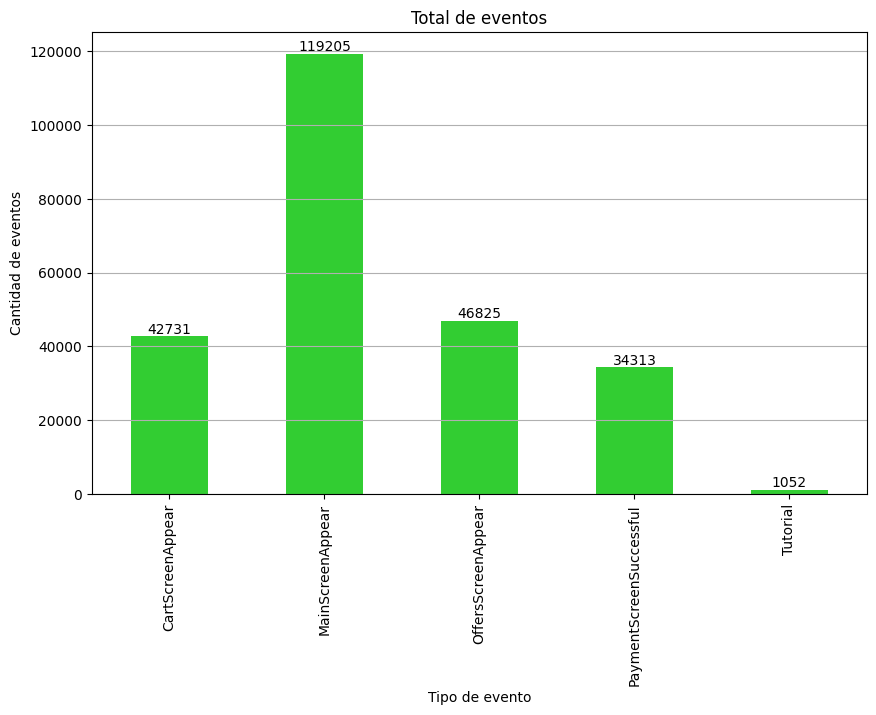

In [17]:
ax = eventos_por_tipo.plot(
    title='Total de eventos', 
    xlabel='Tipo de evento', 
    ylabel='Cantidad de eventos',
    figsize=(10,6),
    color='limegreen',
    kind='bar')

for bar in ax.containers[0]:
    ax.annotate(
        str(int(bar.get_height())),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color ='black')

plt.grid(axis='y')
plt.show()
                     

<span style="color:purple; font-weight:bold">
Al hacer el calculo de los eventos registrados se obtuvo un total de 244,126 dividido en 5 tipos de eventos, siendo el de Main Screen Appear el que tiene la mayoria de los eventos, seguido de Offer Screen Appear, , Cart, Payment y finalmente Tutorial

</span>

### ¿Cuántos usuarios y usuarias hay en los registros?

In [18]:
# usuarios(as) unicas en los registros
usuarios_totales = df_exp['uid'].nunique()
print(f'El total de usuarios/usuarias es de: {usuarios_totales}')

El total de usuarios/usuarias es de: 7551


In [19]:
usuarios_por_evento = df_exp.groupby('event_name')['uid'].nunique()
print(usuarios_por_evento)

event_name
CartScreenAppear           3749
MainScreenAppear           7439
OffersScreenAppear         4613
PaymentScreenSuccessful    3547
Tutorial                    847
Name: uid, dtype: int64


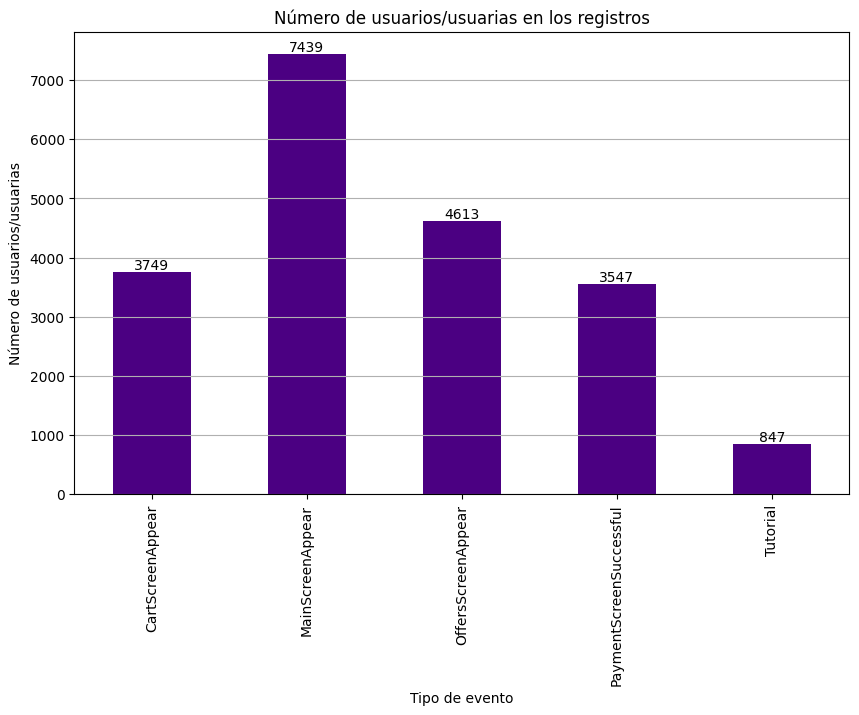

In [20]:
ax = usuarios_por_evento.plot(
    title='Número de usuarios/usuarias en los registros', 
    xlabel='Tipo de evento',
    ylabel='Número de usuarios/usuarias', 
    figsize=(10,6), 
    kind='bar', 
    color='indigo')

# colocar numero en lo alto de la barra
for barra in ax.containers[0]:
    ax.annotate(
        str(int(barra.get_height())),
        (barra.get_x() + barra.get_width() / 2, barra.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

<span style="color:purple; font-weight:bold">
Por otra parte al contabilizar los usuarios unicos se obtuvo un total de 7551, los cuales estan divididos de igual manera en los 5 tipos de eventos, sin embargo las cantidades son mayores al total de usuarios unicos, ya que es posible que algunos de ellos hayan realizado más de una accion en los distintos tipos de eventos. Nuevamente Main Screen es el que mayor cantidad de usuarios tiene, seguido de Offers, Cart, Payment y finalmente Tutorial.

</span>

### ¿Cuál es el promedio de eventos por usuario?

In [21]:
mean_usuarios = (eventos_por_tipo / usuarios_por_evento).round(2)
print(mean_usuarios)

event_name
CartScreenAppear           11.40
MainScreenAppear           16.02
OffersScreenAppear         10.15
PaymentScreenSuccessful     9.67
Tutorial                    1.24
dtype: float64


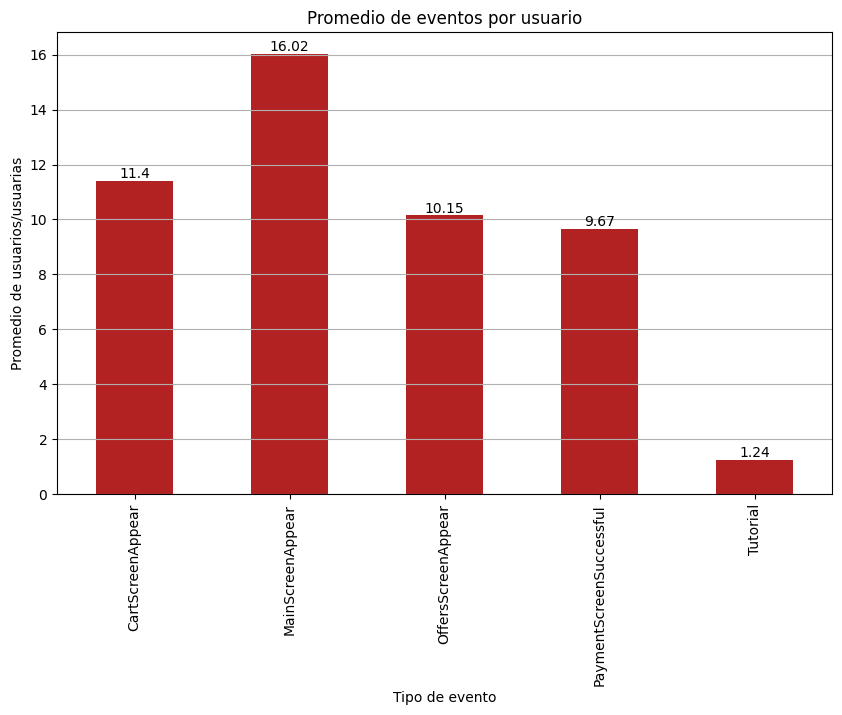

In [22]:
ax = mean_usuarios.plot(
    title='Promedio de eventos por usuario', 
    xlabel='Tipo de evento',
    ylabel='Promedio de usuarios/usuarias', 
    figsize=(10,6), 
    kind='bar', 
    color='firebrick')

# colocar porcentaje en cada barra 
for bar in ax.containers[0]:
    ax.annotate(
        str(float(bar.get_height())),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

<span style="color:purple; font-weight:bold">
El promedio de eventos por usuario fue calculado y se presenta en el anterior grafico, donde Main Screen tiene un promedio de 16.02, seguido de Cart con un promedio de, 11.4, después sigue Offer con un promedio de 10.15, luego Payment con un promedio de 9.67 y finalmente Tutorial con un promedio de 1.24 eventos por usuario

</span>

### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora.

In [23]:
# fecha minima
date_min = df_exp['date_hour'].min()
print(f'La fecha de inicio es: {date_min}')

La fecha de inicio es: 2019-07-25 04:43:36


In [24]:
# fecha maxima
date_max = df_exp['date_hour'].max()
print(f'La fecha final es:{date_max}')

La fecha final es:2019-08-07 21:15:17


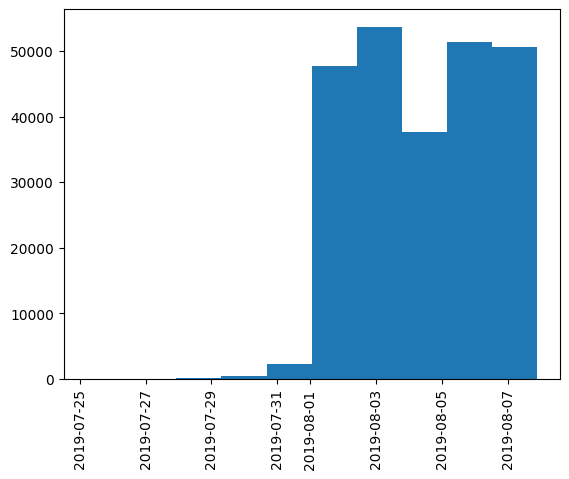

In [25]:
# trazar histograma para conocer la distribucion de las fechas
plt.hist(df_exp['date_hour'], bins=10)

plt.xticks(rotation=90)
plt.show()

<span style="color:purple; font-weight:bold">
Al observar el histograma nos podemos percatar que los datos se encuentran mayormente distribuidos a partir del 1 de Agosto de 2019. Dejando muy pocos valores para el mes de Julio.
</span>

#### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

In [26]:
# filtrar datos entre las fechas de inicio y final 
fecha_inicio = '2019-07-25'
fecha_final = '2019-08-07'

filtro_fecha = (df_exp['date'] >= fecha_inicio) & (df_exp['date'] <= fecha_final)
datos_filtrados = df_exp[filtro_fecha]

In [27]:
#  contar eventos por dia 
eventos_por_dia = datos_filtrados.groupby('date')['event_name'].count()
eventos_por_dia

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: event_name, dtype: int64

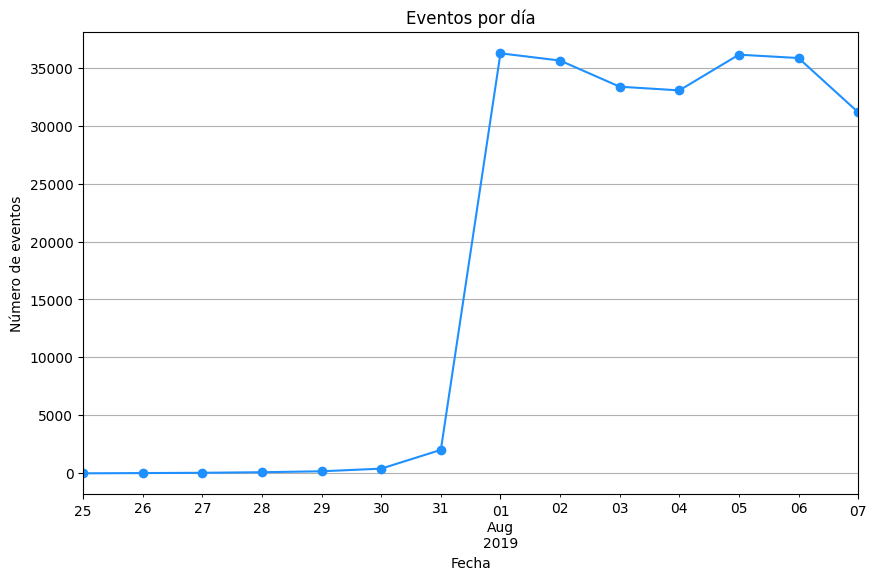

In [28]:
# grafico de lineas 
eventos_por_dia.plot(
    title='Eventos por día', 
    xlabel='Fecha', 
    ylabel='Número de eventos', 
    figsize=(10,6),
    marker='o', 
    color='dodgerblue')

plt.grid(axis='y')
plt.show()

<span style="color:purple; font-weight:bold">
En el grafico de dispersión se observa que efectivamente los eventos del 25 al 31 de Julio son pocos, y a partir del 1 de Agosto los eventos tienen un incremento considerable.

</span>

####  ¿Qué periodo representa realmente los datos?

In [29]:
# filtrar los datos de Julio
periodo_julio = df_exp[df_exp['date'].between('2019-07-25', '2019-07-31')]

In [30]:
# contar el total de eventos para el periodo de Julio
total_eventos_julio = periodo_julio['event_name'].count()
print(f'El total de eventos para el periodo de Julio es de: {total_eventos_julio}')

El total de eventos para el periodo de Julio es de: 2828


In [31]:
# porcentaje que tiene el periodo de julio 
porcentaje_julio = (total_eventos_julio / eventos_totales) * 100
porcentaje_julio = porcentaje_julio.round(2)

print(f'El porcentaje del periodo de Julio es de: {porcentaje_julio}%')

El porcentaje del periodo de Julio es de: 1.16%


In [32]:
# filtrar los datos por el periodo de Agosto
periodo_agosto = df_exp[df_exp['date'].between('2019-08-01', '2019-08-07')]

In [33]:
# contar eventos en el periodo de Agosto
total_eventos_agosto = periodo_agosto['event_name'].count()
print(f'El total de eventos para el periodo de Agosto es de: {total_eventos_agosto}')

El total de eventos para el periodo de Agosto es de: 241298


In [34]:
# porcentaje que tiene el periodo de Agosto
porcentaje_agosto = (total_eventos_agosto / eventos_totales) * 100
porcentaje_agosto = porcentaje_agosto.round(2)

print(f'El porcentaje del periodo de Agosto es de: {porcentaje_agosto}%')

El porcentaje del periodo de Agosto es de: 98.84%


<span style="color:purple; font-weight:bold">
Al realizar un análisis por periodos se obtuvo como resultado que Agosto tiene en 98.84% de los datos, dejando con un 1.16% de los Eventos para el mes de Julio, lo cual significa que Agosto es el periodo que representa realmente los datos. 

</span>

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

#### Eventos perdidos

In [35]:
eventos_julio = periodo_julio.groupby('event_name')['date'].count()
eventos_julio

event_name
CartScreenAppear            366
MainScreenAppear           1774
OffersScreenAppear          475
PaymentScreenSuccessful     200
Tutorial                     13
Name: date, dtype: int64

In [36]:
eventos_julio_total = periodo_julio['event_name'].count()
print(f'El numero de eventos durante Julio es de: {eventos_julio_total}')

El numero de eventos durante Julio es de: 2828


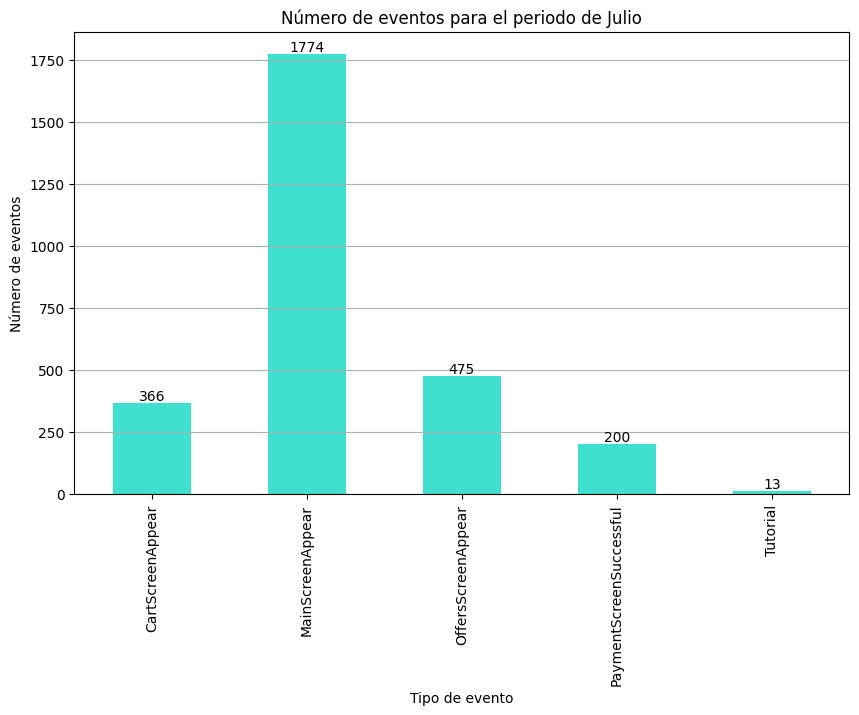

In [37]:
# grafico del numero de eventos para el periodo de julio
ax = eventos_julio.plot(
    title='Número de eventos para el periodo de Julio', 
    xlabel='Tipo de evento',
    ylabel='Número de eventos', 
    figsize=(10,6), 
    kind='bar', 
    color='turquoise')

# colocar numero en lo alto de la barra
for barra in ax.containers[0]:
    ax.annotate(
        str(int(barra.get_height())),
        (barra.get_x() + barra.get_width() / 2, barra.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

In [38]:
eventos_agosto = periodo_agosto.groupby('event_name')['date'].count()
eventos_agosto

event_name
CartScreenAppear            42365
MainScreenAppear           117431
OffersScreenAppear          46350
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: date, dtype: int64

In [39]:
eventos_agosto_total = periodo_agosto['event_name'].count()
print(f'El numero de eventos durante Agosto es de: {eventos_agosto_total}')

El numero de eventos durante Agosto es de: 241298


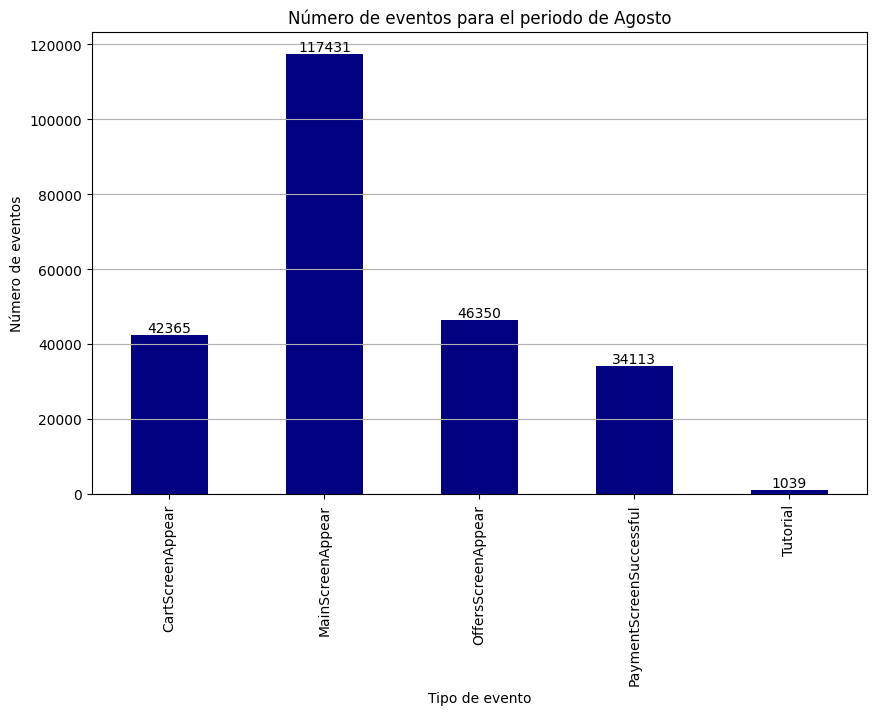

In [40]:
# grafico del numero de eventos para el periodo de agosto
ax = eventos_agosto.plot(
    title='Número de eventos para el periodo de Agosto', 
    xlabel='Tipo de evento',
    ylabel='Número de eventos', 
    figsize=(10,6), 
    kind='bar', 
    color='navy')

# colocar numero en lo alto de la barra
for barra in ax.containers[0]:
    ax.annotate(
        str(int(barra.get_height())),
        (barra.get_x() + barra.get_width() / 2, barra.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

In [41]:
# del total de eventos restar los datos del mes de julio
eventos_excluidos = eventos_totales - eventos_julio_total 

print(f'El total de eventos después de excluir datos es de: {eventos_excluidos}')

El total de eventos después de excluir datos es de: 241298


In [42]:
eventos_excluidos_tipo = eventos_por_tipo - eventos_julio
eventos_excluidos_tipo

event_name
CartScreenAppear            42365
MainScreenAppear           117431
OffersScreenAppear          46350
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: date, dtype: int64

In [43]:
# concatenar los resultados para mostrar grafico de barras
eventos_combinados = pd.concat([eventos_julio, eventos_agosto, eventos_excluidos_tipo], axis='columns')

In [44]:
# cambiar el nombre de las columnas
eventos_combinados.columns = ['Julio', 'Agosto', 'Total de eventos al excluir datos']

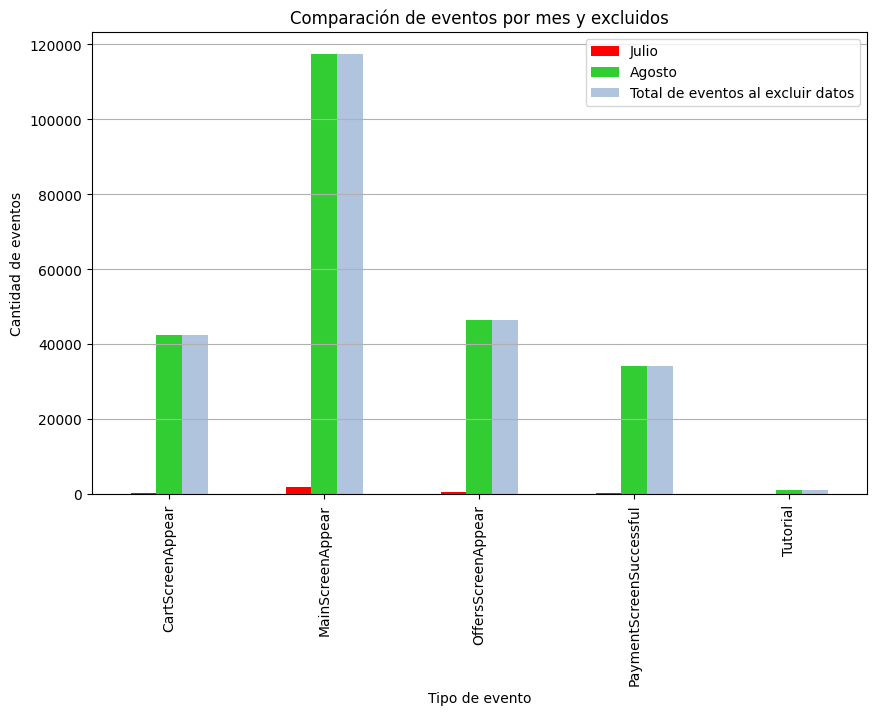

In [45]:
eventos_combinados.plot(
    title="Comparación de eventos por mes y excluidos", 
    xlabel= 'Tipo de evento', 
    ylabel= 'Cantidad de eventos',
    kind='bar', 
    figsize=(10, 6),
    color=['red', 'limegreen', 'lightsteelblue'] 
)


plt.grid(axis='y')
plt.show()

<span style="color:purple; font-weight:bold">
Al analizar cuantos eventos se han perdido al excluir los datos de Julio, se obtuvo que este periodo solo cuenta con 2828 eventos, mientras que el periodo de Agosto tiene 241,298 eventos. Al calcular la diferencia de los eventos totales menos el periodo de Julio se observo que la perdida de eventos es minima, y como se habia explicado anteriormente estos datos solo ocupan el 1.16% del total de Eventos. Por lo cual no hay perdidas significativas.

</span>

#### Usuarios perdidos

In [46]:
# numero de usuarios unicos por evento
usuarios_julio_eventos = periodo_julio.groupby('event_name')['uid'].nunique()
usuarios_julio_eventos

event_name
CartScreenAppear            283
MainScreenAppear           1028
OffersScreenAppear          323
PaymentScreenSuccessful     177
Tutorial                     11
Name: uid, dtype: int64

In [47]:
total_usuarios_julio = periodo_julio['uid'].nunique()
print(f'El total de usuarios en el periodo de Julio son: {total_usuarios_julio} usuarios')

El total de usuarios en el periodo de Julio son: 1451 usuarios


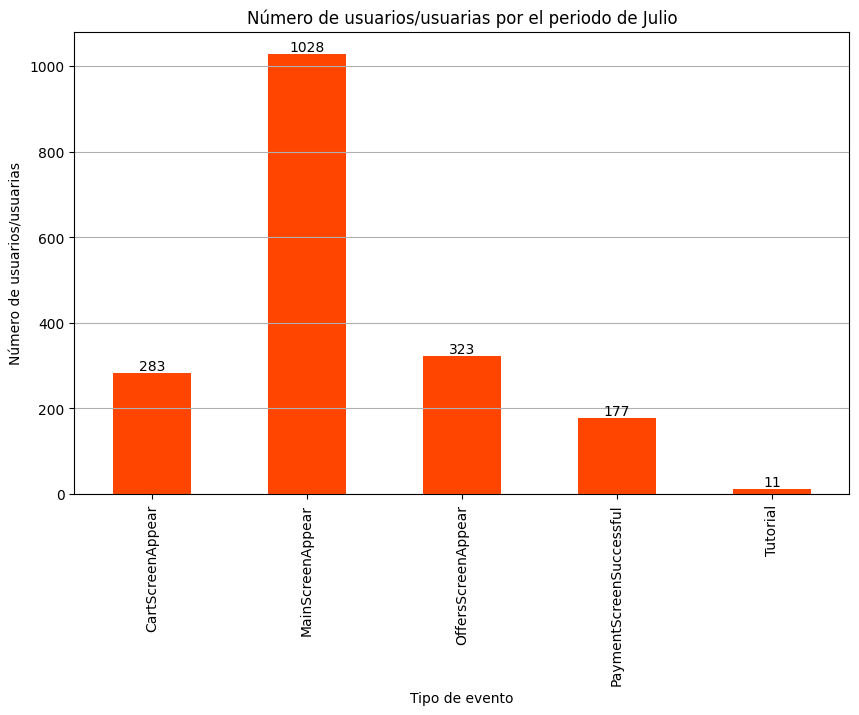

In [48]:
ax = usuarios_julio_eventos.plot(
    title='Número de usuarios/usuarias por el periodo de Julio', 
    xlabel='Tipo de evento',
    ylabel='Número de usuarios/usuarias', 
    figsize=(10,6), 
    kind='bar', 
    color='orangered')

# colocar numero en lo alto de la barra
for barra in ax.containers[0]:
    ax.annotate(
        str(int(barra.get_height())),
        (barra.get_x() + barra.get_width() / 2, barra.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

In [49]:
usuarios_agosto_eventos = periodo_agosto.groupby('event_name')['uid'].nunique()
usuarios_agosto_eventos

event_name
CartScreenAppear           3734
MainScreenAppear           7419
OffersScreenAppear         4593
PaymentScreenSuccessful    3539
Tutorial                    840
Name: uid, dtype: int64

In [50]:
total_usuarios_agosto = periodo_agosto['uid'].nunique()
print(f'El total de usuarios en el periodo de Agosto son: {total_usuarios_agosto} usuarios')

El total de usuarios en el periodo de Agosto son: 7534 usuarios


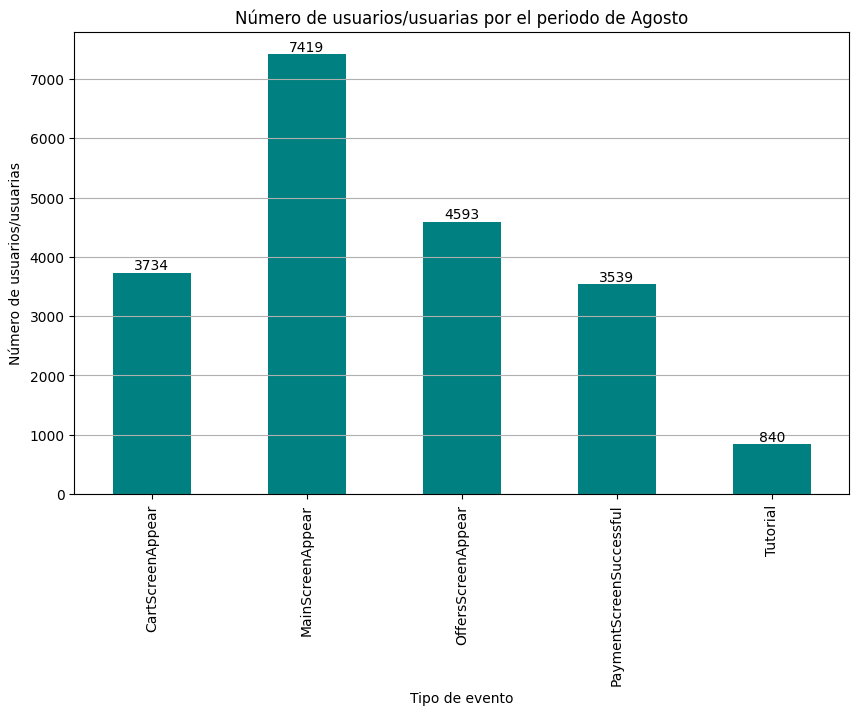

In [51]:
ax = usuarios_agosto_eventos.plot(
    title='Número de usuarios/usuarias por el periodo de Agosto', 
    xlabel='Tipo de evento',
    ylabel='Número de usuarios/usuarias', 
    figsize=(10,6), 
    kind='bar', 
    color='teal')

# colocar numero en lo alto de la barra
for barra in ax.containers[0]:
    ax.annotate(
        str(int(barra.get_height())),
        (barra.get_x() + barra.get_width() / 2, barra.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.grid(axis='y')
plt.show()

In [52]:
# total usuarios al excluir datos
usuarios_excluidos =  usuarios_totales - total_usuarios_julio

print(f'El total de usuarios despues de excluir los datos antiguos es de: {usuarios_excluidos}')

El total de usuarios despues de excluir los datos antiguos es de: 6100


In [53]:
# total usuarios por eventos despues de excluir datos
usuarios_eventos_excluidos = usuarios_por_evento - usuarios_julio_eventos

usuarios_eventos_excluidos

event_name
CartScreenAppear           3466
MainScreenAppear           6411
OffersScreenAppear         4290
PaymentScreenSuccessful    3370
Tutorial                    836
Name: uid, dtype: int64

In [54]:
usuarios_combinados = pd.concat([usuarios_julio_eventos, usuarios_agosto_eventos, usuarios_eventos_excluidos], axis='columns')

In [55]:
usuarios_combinados.columns=['Julio', 'Agosto', 'Total usuarios al excluir datos']

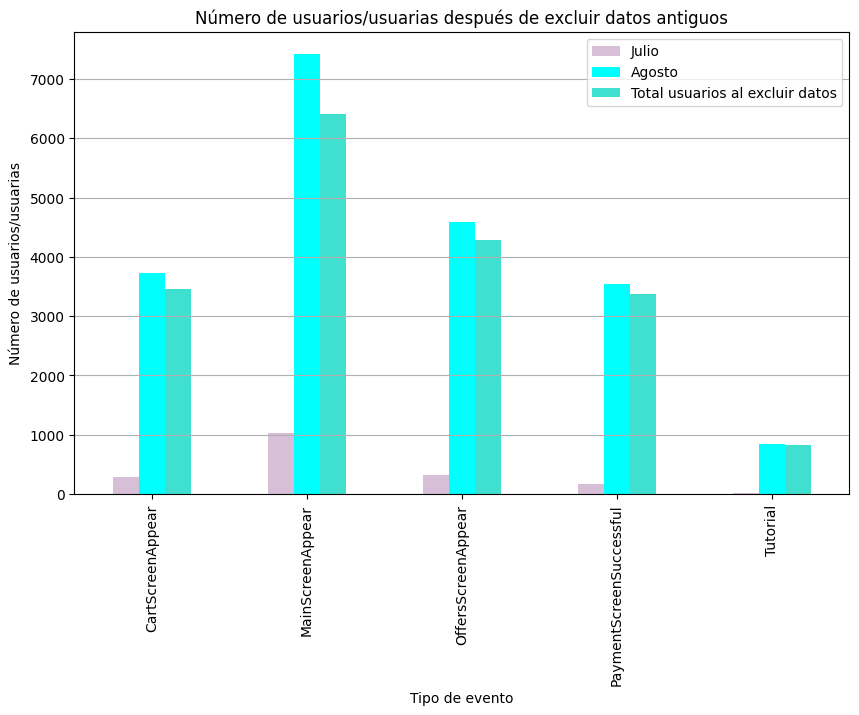

In [56]:
ax = usuarios_combinados.plot(
    title='Número de usuarios/usuarias después de excluir datos antiguos', 
    xlabel='Tipo de evento',
    ylabel='Número de usuarios/usuarias', 
    figsize=(10,6), 
    kind='bar', 
    color=['thistle','cyan','turquoise']
)

plt.grid(axis='y')
plt.show()

<span style="color:purple; font-weight:bold">
En cuanto a la perdida de usuarios, se logra observar que el periodo de Julio cuenta con un total de 1451 usuarios unicos, mientras que Agosto cuenta con 7534 usuarios unicos. En los graficos se logra observar que la cantidad de usuarios es mayor a los antes mencionados, sin embargo es necesario recordar que un usuario pudo haber realizado distintas acciones en los diferentes tipos de eventos. Finalmente al calcular la diferencia entre los usuarios unicos totales y los del periodo de Julio se observa en el ultimo grafico, que de igual manera que en los Eventos, estos no son significativos, y podemos continuar con el análisis.

</span>

### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [57]:
# filtrar los datos
data_246 = periodo_agosto.query('exp_id == 246')

# contar los usuarios unicos del grupo experimental
exitos_246 = data_246['uid'].nunique()

print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 246 es de: {exitos_246}')

El total de usuarios únicos (casos de exito) para el grupo experimental 246 es de: 2484


In [58]:
# filtrar los datos
data_247 = periodo_agosto.query('exp_id == 247')

# contar los usuarios unicos del grupo experimental
exitos_247 = data_247['uid'].nunique()

print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 247 es de: {exitos_247}')

El total de usuarios únicos (casos de exito) para el grupo experimental 247 es de: 2513


In [59]:
# filtrar los datos
data_248 = periodo_agosto.query('exp_id == 248')

# contar los usuarios unicos del grupo experimental
exitos_248 = data_248['uid'].nunique()

print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 248 es de: {exitos_248}')

El total de usuarios únicos (casos de exito) para el grupo experimental 248 es de: 2537


<span style="color:purple; font-weight:bold">
Al analizar el numero de usuarios unicos por grupo experimental se puede apreciar que los 3 cuentan con un numero muy similar. Lo que permite continuar con el análisis.
</span>

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Excelente trabajo al realizar un análisis exhaustivo de los datos en términos de eventos, usuarios, y periodos de tiempo! Has manejado correctamente el preprocesamiento al identificar la distribución de eventos y usuarios únicos, destacando que el 98.84% de los datos provienen de agosto, mientras que el impacto de los eventos y usuarios de julio es mínimo. Además, asegurar que los grupos experimentales tengan un número similar de usuarios es un paso importante para garantizar la validez del experimento. La visualización de los datos a lo largo del tiempo proporciona una visión clara y útil para continuar con el análisis. ¡Bien hecho!
</div>


## Estudiar el embudo de eventos

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [60]:
# encontrar los eventos por usuario
event_count = periodo_agosto.groupby('event_name')['uid'].count().reset_index()

In [61]:
# renombrar columnas
event_count.columns=['Stage', 'Quantity']

In [62]:
# ordenar los eventos por cantidad 
event_count.sort_values(by='Quantity', ascending=False, inplace=True)

In [63]:
event_count

,Stage,Quantity
1,MainScreenAppear,117431
2,OffersScreenAppear,46350
0,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


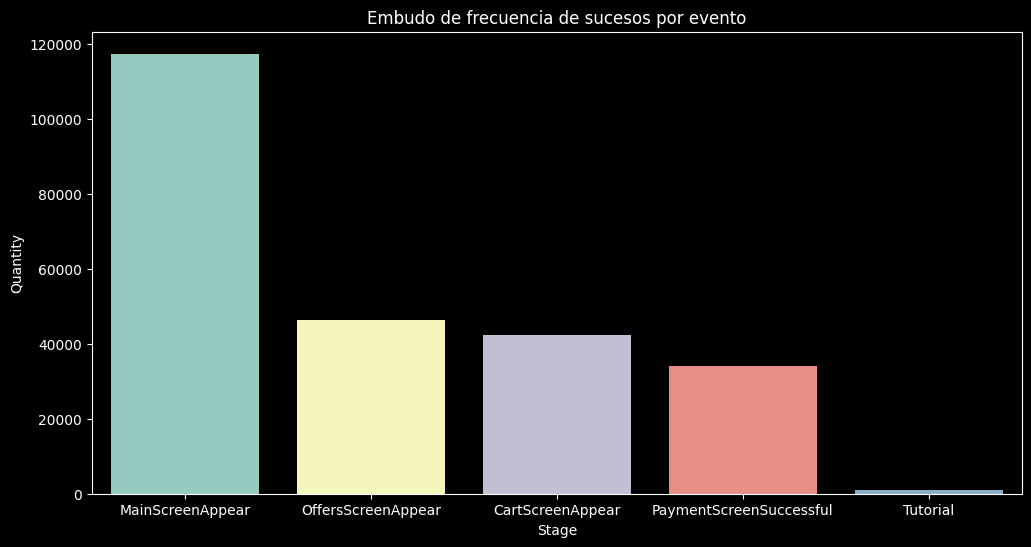

In [64]:
plt.style.use("dark_background")
plt.figure(figsize=(12,6))

sns.barplot(
    x='Stage', 
    y='Quantity', 
    data=event_count)

plt.title('Embudo de frecuencia de sucesos por evento')
plt.show()

<span style="color:purple; font-weight:bold">
Para poder identificar la frecuencia de eventos fue necesario construir un embudo, en el cual se observa que las fases tienen un orden comenzando por Main Screen, siguiendo con Offer Screen, Cart Screen y Payment Screen, lo cual al compararlo con otros sitios web, tienen un orden común (sucede en cualquier otro sitio). Sin embargo, la parte final del embudo, es decir, el evento Tutorial es el que menos frecuencia tiene lo que podria indicar que muchos usuarios omiten esta fase o la desconocen. 
</span>

### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. 

In [65]:
# encontrar los eventos por usuario unico 
user_uniq = periodo_agosto.groupby('event_name').agg({'uid':'nunique'})
print(user_uniq.sort_values(by='uid', ascending=False))

                          uid
event_name                   
MainScreenAppear         7419
OffersScreenAppear       4593
CartScreenAppear         3734
PaymentScreenSuccessful  3539
Tutorial                  840


### Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [66]:
# calcular las proporciones 
proporciones = user_uniq / total_usuarios_agosto * 100
print(proporciones.sort_values(by='uid', ascending=False).round(2))

                           uid
event_name                    
MainScreenAppear         98.47
OffersScreenAppear       60.96
CartScreenAppear         49.56
PaymentScreenSuccessful  46.97
Tutorial                 11.15


<span style="color:purple; font-weight:bold">
Al calcular las proporciones se observa que el 98.47% de usuarios entrar a la pagina principal, después un 60.96% entrar a la pagina de ofertas, seguido de un 49.56% de usuarios que entran a la pagina de carrito y finalmente el 46.97% completa el pago, esto hay que recordar es de usuarios que al menos una vez han realizado estas acciones. Por otra parte la fase de Tutorial vuelve a presentar una proporcion baja de usuarios.
</span>

### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?

In [67]:
# agrupar por usuario y evento para encontrar el primer evento que occurrio
event_order = periodo_agosto.groupby(['uid', 'event_name'])['date_hour'].min().reset_index()

In [68]:
# crear columna nueva donde se almacenen el orden de los eventos
event_order['event_order'] = event_order.groupby('uid')['date_hour'].rank(method='first')

In [69]:
# ordenar por usuario y el orden en que sucedieron los eventos 
event_order_sorted = event_order.sort_values(by=['uid', 'event_order'])

In [70]:
event_order_sorted.head(20)

,uid,event_name,date_hour,event_order
0,6888746892508752,MainScreenAppear,2019-08-06 14:06:34,1.0
2,6909561520679493,MainScreenAppear,2019-08-06 18:52:54,1.0
1,6909561520679493,CartScreenAppear,2019-08-06 18:52:58,2.0
4,6909561520679493,PaymentScreenSuccessful,2019-08-06 18:52:58,3.0
3,6909561520679493,OffersScreenAppear,2019-08-06 18:53:04,4.0
6,6922444491712477,MainScreenAppear,2019-08-04 14:19:33,1.0
5,6922444491712477,CartScreenAppear,2019-08-04 14:19:40,2.0
8,6922444491712477,PaymentScreenSuccessful,2019-08-04 14:19:40,3.0
7,6922444491712477,OffersScreenAppear,2019-08-04 14:19:46,4.0
9,7435777799948366,MainScreenAppear,2019-08-05 08:06:34,1.0


<span style="color:purple; font-weight:bold">
Al analizar el orden de las acciones de los usuarios se logra observar que no todos los usuarios tienen una secuencia completa, ya que algunos entran a Main Screen y a Offer Screen, pero ahi termina su secuencia. hay otros usuarios que incluso empiezan su secuencia en Cart Screen y concluyen con Payment Screen. Por lo que no todos los usuarios cumplen con la secuencia esperada. 
</span>

### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente.

In [71]:
user_pivot = periodo_agosto.pivot_table(
    index='uid',
    columns='event_name',
    values='date_hour',
    aggfunc='min'
)

In [72]:
user_pivot.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
uid,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


In [73]:
# declarar los pasos 
step_1 = ~user_pivot['MainScreenAppear'].isna()
step_2 = step_1 & (user_pivot['OffersScreenAppear'] > user_pivot['MainScreenAppear'])
step_3 = step_2 & (user_pivot['CartScreenAppear'] > user_pivot['OffersScreenAppear'])
step_4 = step_3 & (user_pivot['PaymentScreenSuccessful'] > user_pivot['CartScreenAppear'])
step_5 = step_4 & (user_pivot['Tutorial'] > user_pivot['PaymentScreenSuccessful'])

In [74]:
# crear variables con los pasos de la hora de su primer visita y los que realizaron la accion
n_mainScreen = user_pivot[step_1].shape[0]
n_offers = user_pivot[step_2].shape[0]
n_cart = user_pivot[step_3].shape[0]
n_payment = user_pivot[step_4].shape[0]
n_tutorial = user_pivot[step_5].shape[0]

In [75]:
print('Visitantes:', n_mainScreen)
print('Vio pagina de oferta:', n_offers)
print('Se agregó un producto al carrito:', n_cart)
print('Pagado:', n_payment)
print('Vio Tutorial: ', n_tutorial)

Visitantes: 7419
Vio pagina de oferta: 4201
Se agregó un producto al carrito: 1767
Pagado: 454
Vio Tutorial:  1


<span style="color:purple; font-weight:bold">
Al realizar el embudo de secuencias de usuarios que pasan a otra fase se obtuvo que de un total de 7419 usuarios que visitaron Main Screen la siguiente etapa solo consiguio mantener a 4201 usuarios, despues los usuarios que llegan a Cart Screen son 1767 y por ultimo, solo 454 usuarios pagan la orden. Esto recordemos es de los usuarios que siguen con una secuencia esperada, es decir, comenzando en la etapa 1 y terminando en la etapa 4.
</span>

### ¿En qué etapa pierdes más usuarios y usuarias?

In [76]:
# crear diccionario con los datos obtenidos
embudo_usuarios = {
    'MainScreenAppear' : n_mainScreen,
    'OffersScreenAppear' : n_offers,
    'CartScreenAppear' : n_cart,
    'PaymentScreenSuccessful' : n_payment,
    'Tutorial' : n_tutorial
}

In [77]:
# crear DF con los datos del embudo
df_embudo = pd.DataFrame(list(embudo_usuarios.items()))

# renombrar columnas
df_embudo.columns=['event_name', 'usuarios_despues_embudo']

In [78]:
# resetear index de usuarios unicos iniciales y renombrar columnas
user_unico = user_uniq.sort_values(by='uid', ascending=False).reset_index()
user_unico.columns= ['event_name', 'usuarios_iniciales']

In [79]:
# combinar los DF 
df_comparativo = user_unico.merge(df_embudo, on='event_name')

In [80]:
# calcular la diferencia entre los usuarios inciales y los que restan despues del embudo
df_comparativo['usuarios_perdidos'] = df_comparativo['usuarios_iniciales'] - df_comparativo['usuarios_despues_embudo']

In [81]:
df_comparativo

,event_name,usuarios_iniciales,usuarios_despues_embudo,usuarios_perdidos
0,MainScreenAppear,7419,7419,0
1,OffersScreenAppear,4593,4201,392
2,CartScreenAppear,3734,1767,1967
3,PaymentScreenSuccessful,3539,454,3085
4,Tutorial,840,1,839


<span style="color:purple; font-weight:bold">
Al realizar el calculo de los usuarios que se pierden entre etapas se puede observar que se pierden mas usuarios de la etapa Cart Screen a Payment Screen con un total de 3085 usuarios. Tambien es importante señalar que de la etapa Main a Offers hay una perdida de 2826 usuarios
</span>

### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [82]:
# crear columna con porcentajes de usuarios que concluyen la compra
df_comparativo['conversion_siguiente_etapa'] = (
    df_comparativo['usuarios_despues_embudo'] / df_comparativo['usuarios_iniciales']) * 100

In [83]:
# redondear a 2 digitos
df_comparativo['conversion_siguiente_etapa'] = df_comparativo['conversion_siguiente_etapa'].round(2)

In [84]:
df_comparativo

,event_name,usuarios_iniciales,usuarios_despues_embudo,usuarios_perdidos,conversion_siguiente_etapa
0,MainScreenAppear,7419,7419,0,100.00
1,OffersScreenAppear,4593,4201,392,91.47
2,CartScreenAppear,3734,1767,1967,47.32
3,PaymentScreenSuccessful,3539,454,3085,12.83
4,Tutorial,840,1,839,0.12


<span style="color:purple; font-weight:bold">
Al analizar el porcentaje de usuarios que se hacen todo el viaje desde su primer evento hasta el pago solo alcanzamos un 12.83 % del total de usuarios. 
</span>

## Estudiar los resultados del experimento

### ¿Cuántos usuarios y usuarias hay en cada grupo?

#### Total usuarios grupo control 246

In [85]:
# Calcular el total de usuarios para el periodo de agosto del grupo control 246
total_246 = data_246.shape[0]
print('el total de usuarios para el grupo 246 es de:', total_246)

el total de usuarios para el grupo 246 es de: 79425


In [86]:
# mostrar los casos de exito del grupo 246
print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 246 es de: {exitos_246}')

El total de usuarios únicos (casos de exito) para el grupo experimental 246 es de: 2484


#### Total usuarios grupo control 247

In [87]:
# Calcular el total de usuarios para el periodo de agosto del grupo control 247
total_247 = data_247.shape[0]
print('el total de usuarios para el grupo 247 es de:', total_247)

el total de usuarios para el grupo 247 es de: 77147


In [88]:
# mostrar los casos de exito del grupo 247
print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 247 es de: {exitos_247}')

El total de usuarios únicos (casos de exito) para el grupo experimental 247 es de: 2513


#### Total usuarios grupo experimental 248

In [89]:
# Calcular el total de usuarios para el periodo de agosto del grupo experimental 248
total_248 = data_248.shape[0]
print('el total de usuarios para el grupo 248 es de:', total_248)

el total de usuarios para el grupo 248 es de: 84726


In [90]:
# mostrar los casos de exito del grupo 248
print(f'El total de usuarios únicos (casos de exito) para el grupo experimental 248 es de: {exitos_248}')

El total de usuarios únicos (casos de exito) para el grupo experimental 248 es de: 2537


### Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [91]:
# nivel de significancia 
alpha = 0.05

# crear arrays con datos de los grupos 246 y 247 
exitos = np.array([2484, 2513])
pruebas = np.array([79425, 77147])

# proporcion de exito en el primer grupo 
p1 = exitos[0] / pruebas[0]

# proporcion de exito en el segundo grupo 
p2 = exitos[1] / pruebas[1]

# proporcion de exito combinado 
p_combinado = (exitos[0] + exitos[1]) / (pruebas[0] + pruebas[1])

diferencia = p1 - p2

In [92]:
# calcular las desviaciones estandar de la distribucion normal 
z_value = diferencia / mth.sqrt(p_combinado * (1 - p_combinado) * (1/pruebas[0] + 1/pruebas[1]))

# establecer la distribucion normal estandar (media 0, desviacion estandar 1)

distr = stats.norm(0,1)

In [93]:
# calcular p valor 
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value: 0.14363187004102285
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


<span style="color:purple; font-weight:bold">
Para comprobar esta hipotesis se calcularon la diferencia entre las proporciones de las muestras utilizando el total de usuarios para cada grupo y los casos de exito, es decir, los usuarios unicos que realizaron acciones en los eventos. Asi se calculo el puntaje Z para concer cuantas desviaciones estandar estaban una muestra de la otra. Lo que dio como resultado un p-value de 0.14 y con un nivel de significancia del 0.05, lo cual indica que no se puede rechazar la hipótesis nula y por ende no hay una razon por lo cual pensar que las proporciones son diferentes
</span>

### Crear una funcion para: selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción.

In [94]:
def proporcion_eventos_por_grupo(df, grupo_id):
    #filtrar los datos por grupo
    df_grupo = df[df['exp_id'] == grupo_id]
    
    # obtener el total de usuarios unicos
    total_usuarios_unicos = df_grupo['uid'].nunique()
    
    # agrupar por evento y contar los usuarios unicos en cada evento
    evento_count = df_grupo.groupby('event_name')['uid'].nunique().sort_values(ascending=False)
    
    print(f"\nProporciones para el grupo {grupo_id}\n")
    
    # ciclo for para calcular y mostrar la proporcion de cada evento
    for evento, usuarios_unicos in evento_count.items():
        proporcion = (usuarios_unicos / total_usuarios_unicos) * 100
    
        print(f"Evento: {evento} - Usuarios únicos {usuarios_unicos} (proporcion {proporcion:.2f}%)")

In [95]:
proporcion_eventos_por_grupo(periodo_agosto, 246)


Proporciones para el grupo 246

Evento: MainScreenAppear - Usuarios únicos 2450 (proporcion 98.63%)
Evento: OffersScreenAppear - Usuarios únicos 1542 (proporcion 62.08%)
Evento: CartScreenAppear - Usuarios únicos 1266 (proporcion 50.97%)
Evento: PaymentScreenSuccessful - Usuarios únicos 1200 (proporcion 48.31%)
Evento: Tutorial - Usuarios únicos 278 (proporcion 11.19%)


In [96]:
proporcion_eventos_por_grupo(periodo_agosto, 247)


Proporciones para el grupo 247

Evento: MainScreenAppear - Usuarios únicos 2476 (proporcion 98.53%)
Evento: OffersScreenAppear - Usuarios únicos 1520 (proporcion 60.49%)
Evento: CartScreenAppear - Usuarios únicos 1238 (proporcion 49.26%)
Evento: PaymentScreenSuccessful - Usuarios únicos 1158 (proporcion 46.08%)
Evento: Tutorial - Usuarios únicos 283 (proporcion 11.26%)


<span style="color:purple; font-weight:bold">
Esta funcion ayuda a calcular la proporcion de cada uno de los grupos control en donde se puede visualizar la cantidad de usuarios unicos y que proporcion tienen en cada tipo de eventos
</span>

#### Comprueba si la diferencia entre los grupos es estadísticamente significativa.

In [112]:
def comparar_proporciones(df, evento):
    # filtrar usuarios que realizaron el evento para cada grupo 
    grupo_246 = df[(df['exp_id'] == 246) & (df['event_name'] == evento)]['uid'].nunique()
    grupo_247 = df[(df['exp_id'] == 247) & (df['event_name'] == evento)]['uid'].nunique()    
    
    # obtener usuarios unicos por grupo 
    total_246 = df[df['exp_id'] == 246 ]['uid'].nunique()
    total_247 = df[df['exp_id'] == 247 ]['uid'].nunique()
    
    # numero de exito y tamaño de la muestra 
    exitos = np.array([grupo_246, grupo_247])
    prueba = np.array([total_246, total_247])
    
    # aplicar la prueba de dos proporciones
    stat, p_value = proportions_ztest(exitos, prueba)
    
    # Resultados
    print(f"\nComparación para el evento: {evento}")
    print(f"Grupo 246: Usuarios que realizan evento: {grupo_246} / Usuarios unicos: {total_246} / proporcion:({grupo_246 / total_246 * 100:.2f}%)")
    print(f"Grupo 247: Usuarios que realizan evento: {grupo_247} / Usuarios unicos: {total_247} / proporcion:({grupo_247 / total_247 * 100:.2f}%)")
    print(f"p-value: {p_value}")
    
    if p_value < 0.05:
        print("Diferencia estadísticamente significativa entre los grupos.")
    else:
        print("No hay diferencia estadísticamente significativa entre los grupos.")

In [113]:
comparar_proporciones(periodo_agosto,'MainScreenAppear')


Comparación para el evento: MainScreenAppear
Grupo 246: Usuarios que realizan evento: 2450 / Usuarios unicos: 2484 / proporcion:(98.63%)
Grupo 247: Usuarios que realizan evento: 2476 / Usuarios unicos: 2513 / proporcion:(98.53%)
p-value: 0.7570597232046099
No hay diferencia estadísticamente significativa entre los grupos.


In [114]:
comparar_proporciones(periodo_agosto,'OffersScreenAppear')


Comparación para el evento: OffersScreenAppear
Grupo 246: Usuarios que realizan evento: 1542 / Usuarios unicos: 2484 / proporcion:(62.08%)
Grupo 247: Usuarios que realizan evento: 1520 / Usuarios unicos: 2513 / proporcion:(60.49%)
p-value: 0.2480954578522181
No hay diferencia estadísticamente significativa entre los grupos.


In [115]:
comparar_proporciones(periodo_agosto,'CartScreenAppear')


Comparación para el evento: CartScreenAppear
Grupo 246: Usuarios que realizan evento: 1266 / Usuarios unicos: 2484 / proporcion:(50.97%)
Grupo 247: Usuarios que realizan evento: 1238 / Usuarios unicos: 2513 / proporcion:(49.26%)
p-value: 0.22883372237997213
No hay diferencia estadísticamente significativa entre los grupos.


In [116]:
comparar_proporciones(periodo_agosto,'PaymentScreenSuccessful')


Comparación para el evento: PaymentScreenSuccessful
Grupo 246: Usuarios que realizan evento: 1200 / Usuarios unicos: 2484 / proporcion:(48.31%)
Grupo 247: Usuarios que realizan evento: 1158 / Usuarios unicos: 2513 / proporcion:(46.08%)
p-value: 0.11456679313141847
No hay diferencia estadísticamente significativa entre los grupos.


In [117]:
comparar_proporciones(periodo_agosto,'Tutorial')


Comparación para el evento: Tutorial
Grupo 246: Usuarios que realizan evento: 278 / Usuarios unicos: 2484 / proporcion:(11.19%)
Grupo 247: Usuarios que realizan evento: 283 / Usuarios unicos: 2513 / proporcion:(11.26%)
p-value: 0.9376996189257114
No hay diferencia estadísticamente significativa entre los grupos.


<span style="color:purple; font-weight:bold">
Por otra parte se declaro otra funcion la cual permite comparar cada uno de los eventos por Grupo Control y calculando la significancia de cada uno. Esto dio como resultado que en ninguno de los dos Grupos hay una diferencia significativa al comparar los distintos tipos de Eventos.
</span>

#### ¿Puedes confirmar que los grupos se dividieron correctamente?

In [118]:
# crear arrays con la informacion de usuarios unicos que realizaron acciones 
array_246 = [2450, 1542, 1266, 1200, 278]

array_247 = [2476, 1520, 1238, 1158, 283]

In [119]:
# aplicar prueba U de mann para comprobar que los grupos se dividieron correctamente
resultados_control = stats.mannwhitneyu(array_246, array_247)

print('p-value', resultados_control.pvalue)

if(resultados_control.pvalue < alpha):
    print('Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los grupos')
else:
    print('No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos')

p-value 1.0
No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos


<span style="color:purple; font-weight:bold">
Para verificar que los grupos control fueron correctamente divididos se implemento la prueba U de Mann la cual con un nivel de significancia del 0.05 arrojo un p-value de 1.0 lo que indica que no se puede rechazar la hipótesis nula, es decir, que no existen diferencias significativas en la distribución de los grupos, lo que indica que fueron correctamente divididos.
</span>

### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. 

In [120]:
proporcion_eventos_por_grupo(periodo_agosto, 248)


Proporciones para el grupo 248

Evento: MainScreenAppear - Usuarios únicos 2493 (proporcion 98.27%)
Evento: OffersScreenAppear - Usuarios únicos 1531 (proporcion 60.35%)
Evento: CartScreenAppear - Usuarios únicos 1230 (proporcion 48.48%)
Evento: PaymentScreenSuccessful - Usuarios únicos 1181 (proporcion 46.55%)
Evento: Tutorial - Usuarios únicos 279 (proporcion 11.00%)


In [106]:
# crear array con los datos del grupo experimental 
array_248 = [ 2493, 1531, 1230, 1181, 279]

# aplicar prueba U de mann para comprobar que los grupos se dividieron correctamente
resultados_exp246_aislado = stats.mannwhitneyu(array_248, array_246)

print('p-value', resultados_exp246_aislado.pvalue)

if(resultados_exp246_aislado.pvalue < alpha):
    print('Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los grupos')
else:
    print('No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos')

p-value 1.0
No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos


In [107]:
# aplicar prueba U de mann para comprobar que los grupos se dividieron correctamente
resultados_exp247_aislado = stats.mannwhitneyu(array_248, array_247)

print('p-value', resultados_exp247_aislado.pvalue)

if(resultados_exp247_aislado.pvalue < alpha):
    print('Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los grupos')
else:
    print('No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos')

p-value 1.0
No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos


<span style="color:purple; font-weight:bold">
Al comparar los grupos control con el experimental aisladamente, se aplico nuevamente una prueba U de Mann y se encontro que en ningun caso existe una diferencia en las distribuciones, por lo cual no se puede rechazar la hipótesis nula.
</span>

#### Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [108]:
# sumar los valores de cada uno de los grupo control
array_combinado = []

for valor in range(len(array_246)):
    sumar_valores = array_246[valor] + array_247[valor]
    array_combinado.append(sumar_valores)
print(array_combinado)

[4926, 3062, 2504, 2358, 561]


In [109]:
# aplicar prueba U de mann para comprobar que los grupos se dividieron correctamente
resultado1 = stats.mannwhitneyu(array_248, array_combinado)

print('p-value', resultado1.pvalue)

if(resultado1.pvalue < alpha):
    print('Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los grupos')
else:
    print('No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos')

p-value 0.15079365079365079
No se puede rechazar la hipótesis nula: no existen diferencias sobre la distribución de los grupos


<span style="color:purple; font-weight:bold">
Al comparar los grupos control combinados con el experimental,  se aplico nuevamente una prueba U de Mann con un alpha de 0.05 obteniendo un valor p de 0.15, lo cual indica que no se puede rechazar la hipótesis nula, esto significa que no hay diferencias en las distribuciones de los grupos control y el experimental, lo cual indica que fueron correctamente distribuidos. 
</span>

### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? 

In [110]:
# analizar los datasets con la prueba bonferroni 
sample_A = array_246
sample_B = array_247
sample_C = array_248

In [111]:
# nivel de significancia 
alpha = 0.05

# realizar prueba t grupos independientes haciendo 3 comparaciones
results_AB = stats.ttest_ind(sample_A, sample_B)

results_BC = stats.ttest_ind(sample_B, sample_C)

results_AC = stats.ttest_ind(sample_A, sample_C)

# tres comparaciones realizadas
bonferroni_alpha = alpha / 3

print(f'El resultado de la prueba Bonfferroni es: {bonferroni_alpha}')
print('valor p para comparar los grupos A y B: ', results_AB.pvalue)
print('valor p para comparar los grupos B y C: ', results_BC.pvalue)
print('valor p para comparar los grupos A y C: ', results_AC.pvalue)

if (results_AB.pvalue < bonferroni_alpha):
    print("Hipótesis nula rechazada para los grupos А y B")
else:
    print("Hipótesis nula no rechazada para los grupos А y B")
if (results_BC.pvalue < bonferroni_alpha):
    print("Hipótesis nula rechazada para los grupos B y C")
else:
    print("Hipótesis nula no rechazada para los grupos B y C")
if (results_AC.pvalue < bonferroni_alpha):
    print("Hipótesis nula rechazada para los grupos A y C")
else:
    print("Hipótesis nula no rechazada para los grupos А y C")

El resultado de la prueba Bonfferroni es: 0.016666666666666666
valor p para comparar los grupos A y B:  0.9809573661651472
valor p para comparar los grupos B y C:  0.9879505929915808
valor p para comparar los grupos A y C:  0.9931630297368078
Hipótesis nula no rechazada para los grupos А y B
Hipótesis nula no rechazada para los grupos B y C
Hipótesis nula no rechazada para los grupos А y C


<span style="color:purple; font-weight:bold">
La corrección de Bonferroni ajusta el nivel de significancia original de alpha 0.05 a 0.0167 al dividirlo entre el número de comparaciones (3).

Con este nivel ajustado cualquier valor p que sea menor a 0.0167 indicaría una diferencia estadísticamente significativa entre los grupos. Al observar los resultados de la comparacion entre los grupos se obtienen puntajes superiores al alpha ajustada, lo que podria significar que no hay suficiente evidencia para rechazar la hipotesis nula en ninguna de las comparaciones. 
 
Por lo cual los resultados obtenidos sugieren que los tres grupos (246, 247 y 248) tienen distribuciones muy similares en cuanto al número de usuarios únicos que realizaron cada evento, lo cual es consistente con una correcta asignación de los grupos en el experimento.
</span>